In [19]:
import sys
import os
import glob
import matplotlib.pyplot as pp
import numpy as np
import math

In [2]:
def read_active_sites(dir):
    """
    Read in all of the active sites from the given directory.

    Input: directory
    Output: list of ActiveSite instances
    """
    files = glob.glob(dir + '/*.pdb')

    active_sites = []
    # iterate over each .pdb file in the given directory
    for filepath in glob.iglob(os.path.join(dir, "*.pdb")):

        active_sites.append(read_active_site(filepath))

    print("Read in %d active sites"%len(active_sites))

    return active_sites


def read_active_site(filepath):
    """
    Read in a single active site given a PDB file

    Input: PDB file path
    Output: ActiveSite instance
    """
    basename = os.path.basename(filepath)
    name = os.path.splitext(basename)

    if name[1] != ".pdb":
        raise IOError("%s is not a PDB file"%filepath)

    active_site = ActiveSite(name[0])

    r_num = 0

    # open pdb file
    with open(filepath, "r") as f:
        # iterate over each line in the file
        for line in f:
            if line[0:3] != 'TER':
                # read in an atom
                atom_type = line[13:17].strip()
                x_coord = float(line[30:38])
                y_coord = float(line[38:46])
                z_coord = float(line[46:54])
                atom = Atom(atom_type)
                atom.coords = (x_coord, y_coord, z_coord)

                residue_type = line[17:20]
                residue_number = int(line[23:26])

                # make a new residue if needed
                if residue_number != r_num:
                    residue = Residue(residue_type, residue_number)
                    r_num = residue_number

                # add the atom to the residue
                residue.atoms.append(atom)

            else:  # I've reached a TER card
                active_site.residues.append(residue)

    return active_site


def write_clustering(filename, clusters):
    """
    Write the clustered ActiveSite instances out to a file.

    Input: a filename and a clustering of ActiveSite instances
    Output: none
    """

    out = open(filename, 'w')

    for i in range(len(clusters)):
        out.write("\nCluster %d\n--------------\n" % i)
        for j in range(len(clusters[i])):
            out.write("%s\n" % clusters[i][j])

    out.close()


def write_mult_clusterings(filename, clusterings):
    """
    Write a series of clusterings of ActiveSite instances out to a file.

    Input: a filename and a list of clusterings of ActiveSite instances
    Output: none
    """

    out = open(filename, 'w')

    for i in range(len(clusterings)):
        clusters = clusterings[i]

        for j in range(len(clusters)):
            out.write("\nCluster %d\n------------\n" % j)
            for k in range(len(clusters[j])):
                out.write("%s\n" % clusters[j][k])

    out.close()

# Some utility classes to represent a PDB structure

class Atom:
    """
    A simple class for an amino acid residue
    """

    def __init__(self, type):
        self.type = type
        self.coords = (0.0, 0.0, 0.0)
        self.score = 0

    # Overload the __repr__ operator to make printing simpler.
    def __repr__(self):
        return self.type

class Residue:
    """
    A simple class for an amino acid residue
    """

    def __init__(self, type, number):
        self.type = type
        self.number = number
        self.atoms = []

    # Overload the __repr__ operator to make printing simpler.
    def __repr__(self):
        return "{0} {1}".format(self.type, self.number)

class ActiveSite:
    """
    A simple class for an active site
    """

    def __init__(self, name):
        self.name = name
        self.residues = []

    # Overload the __repr__ operator to make printing simpler.
    def __repr__(self):
        return self.name


In [3]:
def compute_similarity(site_a, site_b):
    """
    Compute the similarity between two given ActiveSite instances.
    
    All of the heavy lifting is done by the active_site_scoring function, which computes a score
    for every active site. To check the similarity just find the absolute difference in the scores. A smaller
    difference means more similar.

    Input: two ActiveSite instances
    Output: the similarity between them (a floating point number)
    """

    similarity = 0.0

    # Fill in your code here!
    
    similarity = abs(site_a.score - site_b.score)
    
    
    return similarity


def cluster_by_partitioning(active_sites, k, iterations):
    """
    Cluster a given set of ActiveSite instances using a partitioning method.
    I am clustering by k_means.

    Input: a list of ActiveSite instances, k clusters, number of k_means iterations
    Output: a clustering of ActiveSite instances
            (this is really a list of clusters, each of which is list of
            ActiveSite instances)
    """
    # Fill in your code here!
    
    ## Initializing k_means dictionary with arbitrary k means
    k_means = {active_sites[i].score:[] for i in range(0,k)}
    
    ## Loop clustering for the desired number of iterations
    for i in range(0, iterations):
        
        ## Find the closest mean for every site in active sites, measured by score
        for site in active_sites:
            closest_mean = 1000000000 ## Initialize with massive value that will hopefully not cause bugs
                                      ## site.scores are centered around 0, so this number should never be met
            
            ## Check how far to every mean, save if closer mean is found
            for k_mean in k_means.keys():
                if abs(site.score - k_mean) < abs(site.score - closest_mean):
                    closest_mean = k_mean
            
            ## Use the closest found mean to append the active site to the k_means dictionary
            k_means[closest_mean].append(site)
        
        ## Placeholder for new k_means dictionary keys
        new_means = [sum([list_item.score for list_item in mean_list])/len(mean_list) for mean_list in k_means.values()]
        
        ## Save old k_means dictionary in case this is the last iteration
        return_means = k_means
        
        ## Create new k_means dictionary using newly generated means
        k_means = {new_mean:[] for new_mean in new_means}

    ## Once all iterations are complete, return the lists of the clustered active sites as a list
    return [value for value in return_means.values()]


def cluster_hierarchically(active_sites, k):
    """
    Cluster the given set of ActiveSite instances using a hierarchical algorithm.                                                                  #

    Input: a list of ActiveSite instances
    Output: a list of clusterings
            (each clustering is a list of lists of Sequence objects)
    """

    # Fill in your code here!
    
    ## Initialize starting clusters (every active site is its own cluster)
    clusters = {active_site:[active_site] for active_site in active_sites}
    
    ## Flag for if the clustering gets stuck, turns it from a reciprocal closest search, to a closest search
    super_add_mode = False
    
    ## While our total clusters are greater than k clusters
    while len(clusters) > k:
        
        ## Determine how many clusters are present (this becomes important at the end of the loop)
        cluster_length = len(clusters)
        
        ## Initialize new cluster dictionary
        new_clusters = {}
        
        ## Initialize best found cluster
        best_cluster = []
        
        ## Initialize best found cluster distance
        best_value = 1000000000
        
        ## Initialize best found cluster dictionary key
        best_key = []

        
        ## Loop over every cluster in the cluster dictionary
        for centroid_main in clusters.keys():
            
            ## Save the value of the current cluster (this is a list)
            centroid_cluster = clusters[centroid_main]
            
            ## Find the closest centroid to the current cluster centroid, excluding the current cluster
            ## Returns the closest cluster, as well as the score difference
            closest_centroid, closest_value = find_closest(centroid_main, clusters, [centroid_main])
            
            ## Find the closest centroid to the closest found centroid, excluding the closest foudn centroid
            reciprocal_centroid, reciprocal_value = find_closest(closest_centroid[0], clusters, closest_centroid)
            
            ## Check to see if both centroids are closest to each other, or see if clustering is stuck
            if centroid_main in reciprocal_centroid or super_add_mode:
                
                ## Is the found cluster score difference better than any other found cluster
                if abs(closest_value) < abs(best_value):
                    
                    ## Set best found value to the cluster score difference
                    best_value = closest_value
                    
                    ## Set the best cluster to this cluster
                    best_cluster = closest_centroid
                    
                    ## Set the best cluster seed key to this cluster seed key
                    best_key = centroid_main
            
            ## Put cluster into new cluster dictionary (both cluster dicts are the same at this point)
            new_clusters[centroid_main] = centroid_cluster
        
        ## If a best cluster was found
        if len(best_cluster) > 0:
            
            ## Add the best cluster seed key to the list of clustered keys
            best_cluster = [best_key] + best_cluster
            
            ## Reset the cluster list
            centroid_cluster = []
            
            ## Remove all clustered elements from the new_clusters dictionary
            for centroid in best_cluster: 
                centroid_cluster = centroid_cluster + clusters[centroid]
                new_clusters.pop(centroid, None)
            
            ## Add the clustered elements back into the new_clusters dictionary under the cluster seed key
            new_clusters[best_key] = centroid_cluster
        
        
        ## Replace the clusters dictionary with the new clusters dictionary, now ready for another round
        clusters = new_clusters
        
        ## Reset the stuck clustering flag
        super_add_mode = False
        
        ## If the original cluster length is the same as the new cluster length, turn on the stuck clustering flag
        if cluster_length == len(clusters):
            print("No new clusters found")
            super_add_mode = True
    
    ## Return a list of clusters  
    return [cluster for cluster in clusters.values()]


def find_closest(check_key, check_dict, banned):
    """
    Find the closest cluster based on centroid, excluding any banned clusters                                                                #

    Input:  Dictionary key for cluster to check against
            Dictionary of clusters
            List of banned clusters (a list of keys)
    Output: The closest cluster, formatted as a list of keys
            The difference between the score of the checked cluster and the closest cluster
    """
    
    ## Find the centroid (average value) of the cluster to check against
    avg_value = find_centroid(check_key, check_dict)
    
    ## Create a list of all clusters in check_dict (a list of lists of active sites)
    cluster_list = [cluster for cluster in check_dict.values()]
    
    ## Checkpoint to make sure everything is working alright
    #  The test_for_validity value is a list of cluster averages
    #  The clust_len value is a total number of elements in cluster_list
    #  A flag can be set to true to display a graph of the clusters based on centroids
    test_for_validity, clust_len = visualize_h_cluster(cluster_list, False)
    
    ## Check to make sure the found centroid is also in the list of cluster averages
    if avg_value not in test_for_validity:
        print(avg_value)
        print(test_for_validity)
    
    ## Initializing a closest score
    closest_score = 1000000000 ## Going all in on massive number initialization
    
    ## Initializing the list of closest keys
    closest = []
    
    ## Initializing a closest difference
    closest_diff = 1000000000
    
    ## Loop over every key in the cluster dictionary to check the distance of every cluster
    for key in check_dict.keys():
        
        ## Make sure the key is not in the excluded list before continuing
        if key not in banned:
            
            ## Find the centroid for key in check_dict
            new_centroid = find_centroid(key, check_dict)
            
            ## If the new centroid is closer than the closest_score, keep the key, centroid, and difference
            if abs(avg_value - new_centroid) < abs(avg_value - closest_score):
                closest_score = new_centroid
                closest_diff = avg_value - new_centroid
                closest = [key]
            
            ## Also check to see if the new centroid is equal to the closest score, append the key
            elif abs(avg_value - new_centroid) == abs(avg_value - closest_score):
                closest.append(key)
    
    ## Return a list of the closest keys, and a float of the closest distance
    return (closest, closest_diff)

def find_centroid(check_key, check_dict):
    """
    Find the centroid of an active site (its average score)                                                              #

    Input:  Dictionary key for cluster to average
            Dictionary of clusters
    Output: The average score of the cluster
    """
    ## For every active site in the cluster, sum the score and divide by the number of sites
    avg_value = sum([value.score for value in check_dict[check_key]])/len(check_dict[check_key])
    return(avg_value)


def visualize_h_cluster(cluster_list, show_plot):
    
    """
    Find the cluster centroids by averaging, return averages and number of elements.
    Make a 1-d plot of the cluster centroids. The major differnece with this averaging method is that
    the input is a list instead of a dictionary. The output helps to check that the total cluster list is
    not growing or shrinking.
    
    This is not really needed anymore, but it really helped while building the hier clustering function
    to visualize that the right things were actually clustering. It also helped to determine if things
    were getting added or deleted to the overall active_site list.
    
    Input:  List of lists of active site clusters
            Boolean show plot
    Output: A list of the average values of the clusters
            An int of the number of total clustered elements
    """
    average_values = []
    clust_len = sum([len(cluster) for cluster in cluster_list])
    for cluster in cluster_list:
        average_values.append(sum([value.score for value in cluster])/len(cluster))
    if show_plot:
        pp.figure(figsize=(20,5))
        y_values = np.zeros_like(average_values)
        pp.plot(average_values, y_values, 'x')
        pp.show()
    return(average_values, clust_len)

In [4]:
def active_site_score(active_sites):
    """
    Determine active_site.score. Normalize based on mean and standard deviation.
    
    Initially active sites are scored on multiple metrics, lysine positions, arginine positions, 
    and overall hydrophobicity.
    
    These initial scores are then normalized around 0 and added together to get active_site.score
    
    This function directly writes to active_site.score.                                                            

    Input:  A list of active sites
    Output: None
    """   
    ## The hydrophobicity dictionary
    score_metric_hydrophobicity = {'ARG': -4.5, 'HIS': -3.2, 'LYS': -3.9, 'ASP': -3.5, 'GLU': -3.5, 'CYS': 2.5, 'GLY': -0.4, 
                               'PRO': -1.6, 'ALA': 1.8,'VAL': 4.2, 'ILE': 4.5, 'LEU': 3.8, 'MET': 1.9, 'PHE': 2.8, 
                               'TYR': -1.3, 'TRP': -0.9, 'SER': -0.8, 'THR': -0.7, 'ASN': -3.5, 'GLN': -3.5}
    
    ## Determining lysine positions
    for active_site in active_sites:
        
        ## Initial lysine vector of 0
        lysine_coord_sum = [0.0, 0.0, 0.0]
        for residue in active_site.residues:
            if residue.type == "LYS":
                for atom in residue.atoms:
                    if atom.type == 'NZ':
                        
                        ## Every time a lysine is found, add the vector
                        lysine_coord_sum[0] += atom.coords[0]
                        lysine_coord_sum[1] += atom.coords[1]
                        lysine_coord_sum[2] += atom.coords[2]
        
        ## Determine the magnitude of the summed lysine vector, and save to active site
        lysine_sum_magnitude = pow(sum([pow(pos, 2) for pos in lysine_coord_sum]), 0.5)
        active_site.lys_score = lysine_sum_magnitude
    
    ## Determine the mean and standard deviation of the lysine magnitudes
    lys_m = sum([active_site.lys_score for active_site in active_sites])/len(active_sites)
    lys_s = sum([abs(active_site.lys_score - lys_m) for active_site in active_sites])/len(active_sites)
    
    
    ## Repeat the same process for arginines
    for active_site in active_sites:
        arg_coord_sum = [0.0, 0.0, 0.0]
        for residue in active_site.residues:
            if residue.type == "ARG":
                for atom in residue.atoms:
                    if atom.type == 'CZ':
                        arg_coord_sum[0] += atom.coords[0]
                        arg_coord_sum[1] += atom.coords[1]
                        arg_coord_sum[2] += atom.coords[2]
        arg_sum_magnitude = pow(sum([pow(pos, 2) for pos in arg_coord_sum]), 0.5)
        active_site.arg_score = arg_sum_magnitude
    
    arg_m = sum([active_site.arg_score for active_site in active_sites])/len(active_sites)
    arg_s = sum([abs(active_site.arg_score - arg_m) for active_site in active_sites])/len(active_sites)
    
    
    ## Hydrophobic score determination usint the dictionary
    for active_site in active_sites:
        active_site.hyd_score = sum([score_metric_hydrophobicity[residue.type] for residue in active_site.residues])
    
    hyd_m = sum([active_site.hyd_score for active_site in active_sites])/len(active_sites)
    hyd_s = sum([abs(active_site.hyd_score - hyd_m) for active_site in active_sites])/len(active_sites)
    
    
    ## For every active site, normalize the scores, then add them together into the master score active_site.score
    for active_site in active_sites:
        active_site.lys_score = (active_site.lys_score - lys_m)/lys_s
        active_site.arg_score = (active_site.arg_score - arg_m)/arg_s
        active_site.hyd_score = (active_site.hyd_score - hyd_m)/hyd_s
        
        active_site.score = active_site.lys_score + active_site.arg_score + active_site.hyd_score    


def cluster_score(cluster_list):
    """
    Determine a score for the cluster based on the active site scores inside of the cluster.
    The cluster score is determined by finding the distance of every active site to the cluster center,
    and summing those distances. Tighter clusters will have smaller sums.
    
    It is a very uncomplicated way of getting a cluster score, but it seems to work.
    
    Input: A list of clusters (the output from the clustering functions)
    Output: sum of distances from cluster mean
    """
    ## For every cluster, find the distance of each active_site.score from the mean
    dist_list = []
    for cluster in cluster_list:
        m = sum([active_site.score for active_site in cluster])/len(cluster)
        
        ## Append the sum of the distances to dist_list
        dist_list.append(sum([abs(active_site.score - m) for active_site in cluster]))
    
    ## Sum up the dist list
    return sum(dist_list)
    

In [9]:
def test_similarity():
    filename_a = os.path.join("data", "276.pdb")
    filename_b = os.path.join("data", "4629.pdb")

    activesite_a = io.read_active_site(filename_a)
    activesite_b = io.read_active_site(filename_b)

    ## These active sites seem fairly different. I am not sure what this is meant for, since the scores
    #  are fairly arbitrary. I am asserting that these sites are different.
    assert cluster.compute_similarity(activesite_a, activesite_b) > 0.0


def test_partition_clustering():
    
    active_sites = read_active_sites("../Data")
    
    active_site_score(active_sites)
    
    ## This section shows that less than 20 iterations are needed until the cluster score converges
    #  it tests up to 100 iterations.
    score_list = [0]
    x_list = []
    for i in range(0, 100):
        score = cluster_score(cluster_by_partitioning(active_sites, 3, i+1))
    
        ## If it is the same for two iterations (only reason for two was to see the convergence line)
        if score == score_list[i-1]:
            score_list = score_list[1:]
            break
        score_list.append(score)
        x_list.append(i+1)   
        
    pp.figure(figsize=(20,10))
    pp.plot(x_list, score_list, 'x-')
    pp.grid(True)
    pp.title("Iterations until cluster score convergence")
    pp.xlabel("number of iterations")
    pp.ylabel("cluster score")
    pp.show()
    
    ## This section shows the clustering quality based on the cluster_score function. The higher the y value
    #  the worse the cluster (many points far from the mean).
    y_part_vals = []
    x_part_vals = []
    step_size = math.floor(len(active_sites)/2/10)

    for i in range(0, 10):
        y_part_vals.append(cluster_score(cluster_by_partitioning(active_sites, i*step_size+1, 20)))
        x_part_vals.append(i*step_size+1)

    pp.figure(figsize=(20,10))
    pp.semilogy(x_part_vals, y_part_vals, 'x-')
    pp.grid(True)
    pp.title("Partition clustering quality by number of clusters")
    pp.xlabel("number of clusters (k)")
    pp.ylabel("cluster score")
    pp.show()
    
    ## Another really large initial number to check against
    y_prev = 1000000000
    
    ## Assert that the overall cluster scores get smaller as the number of clusters increases
    for y in y_part_vals:
        assert y < y_prev
        y_prev = y


def test_hierarchical_clustering():
    ## I am going for all active sites
    
    
    active_sites = read_active_sites("../Data")
    
    active_site_score(active_sites)
    
    y_hier_vals = []
    x_hier_vals = []
    step_size = math.floor(len(active_sites)/2/10)
    for i in range(0,10):
        clusters = cluster_hierarchically(active_sites, i*step_size+1)
        y_hier_vals.append(cluster_score(clusters))
        x_hier_vals.append(i*step_size+1)        
    
    pp.figure(figsize=(20,10))
    pp.semilogy(x_hier_vals, y_hier_vals, 'x-')
    pp.grid(True)
    pp.title("Hierarchical clustering quality by number of clusters")
    pp.xlabel("number of clusters (k)")
    pp.ylabel("cluster score")
    pp.show()

    ## Assert that the overall cluster scores get smaller as the number of clusters increases
    y_prev = 1000000000
    for y in y_hier_vals:
        assert y < y_prev
        y_prev = y
        
def test_cluster_differences():
    
    active_sites = read_active_sites("../Data")
    
    active_site_score(active_sites)
    
    y_comb_vals = []
    x_vals = []
    step_size = math.floor(len(active_sites)/2/4)
    
    for i in range(0,4):
        y_hier_val = cluster_score(cluster_hierarchically(active_sites, i*step_size+1))
        y_part_val = cluster_score(cluster_by_partitioning(active_sites, i*step_size+1, 20))
        
        y_comb_vals.append(y_hier_val - y_part_val)
        
        x_vals.append(i*step_size+1)
    
    pp.figure(figsize=(20,10))
    pp.plot(x_vals, y_comb_vals, 'x-')
    pp.grid(True)
    pp.title("Hierarchical clustering score - Partition clustering score by k")
    pp.xlabel("number of clusters (k)")
    pp.ylabel("cluster score difference")
    pp.show()

Read in 136 active sites


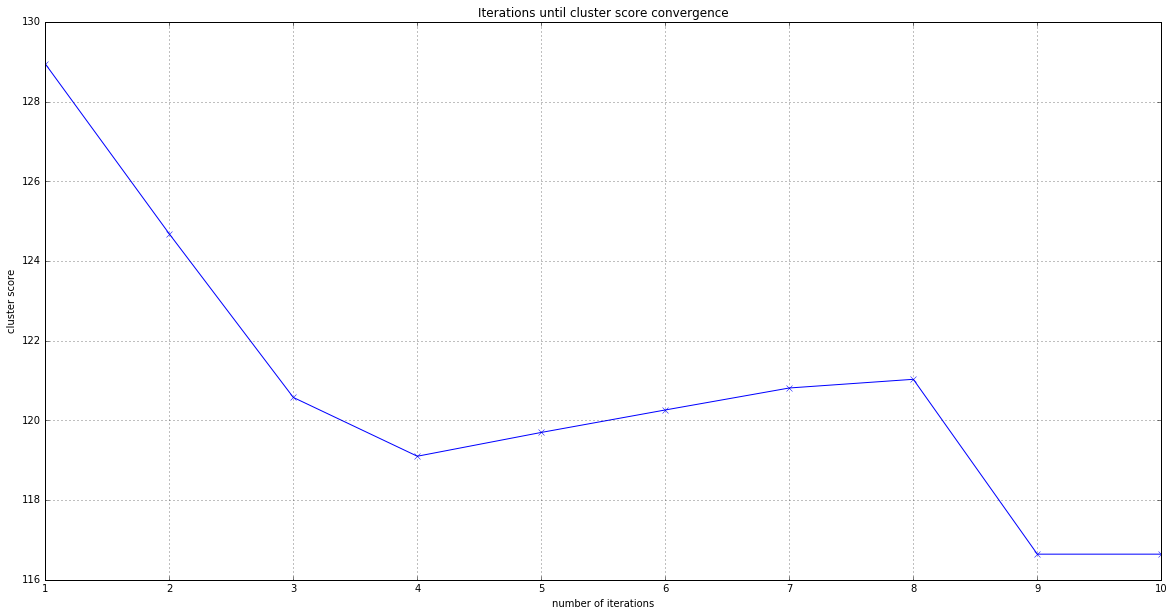

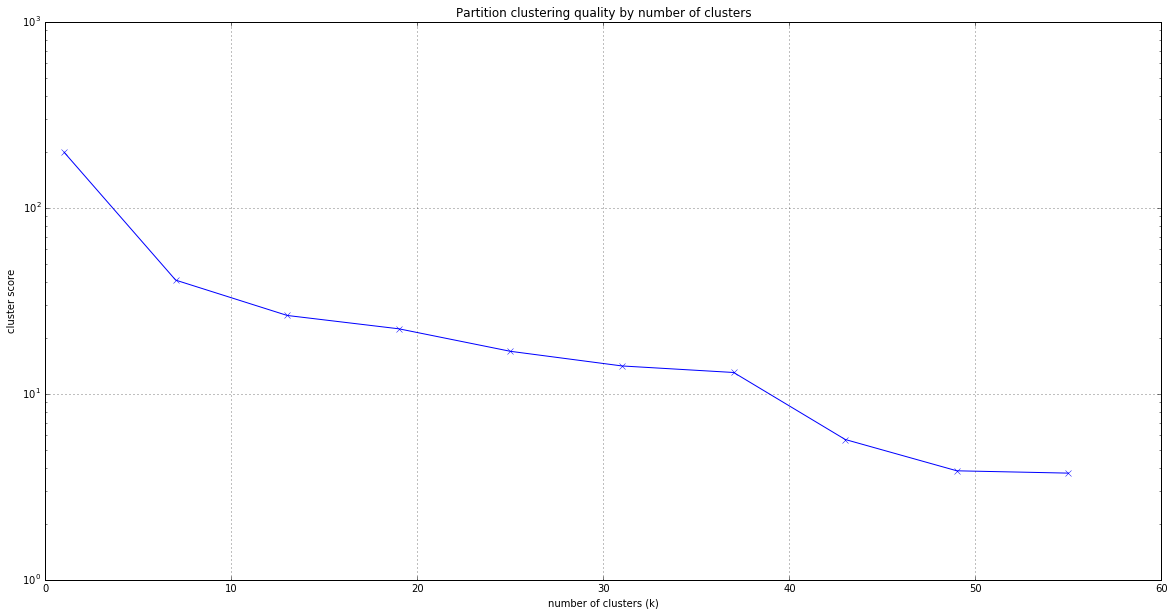

In [6]:
test_partition_clustering()

Read in 136 active sites


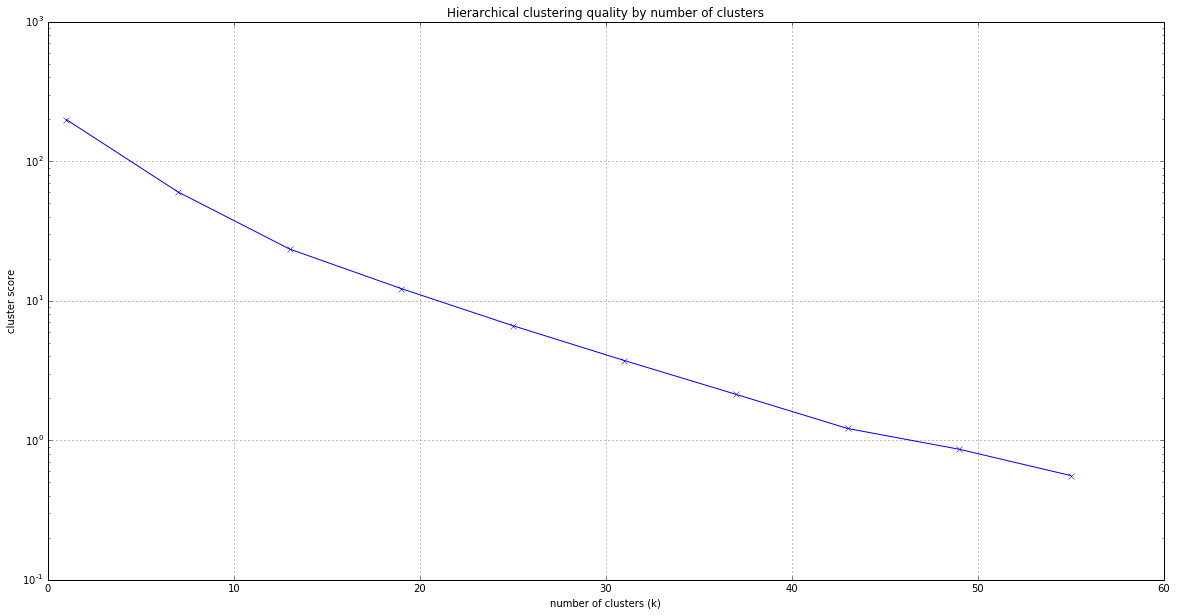

In [7]:
test_hierarchical_clustering()

Read in 136 active sites


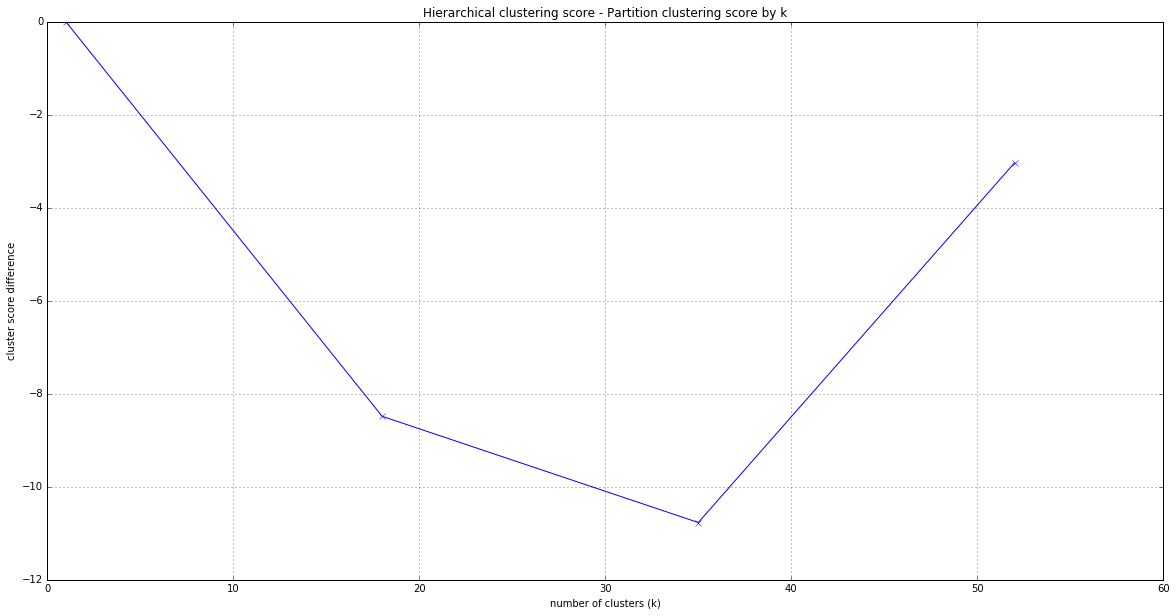

In [10]:
test_cluster_differences()

In [20]:
test_similarity()

NameError: name 'io' is not defined